<center><img src=https://github.com/nccr-itmo/FEDOT/raw/master/docs/fedot_logo.png></img></center>

# <center>Решение задачи регрессии при помощи фреймворка [FEDOT](https://github.com/nccr-itmo/FEDOT)</center>

## Введение

Для решения любой задачи при помощи методов машинного обучения, исследователю требуется пройти множество шагов: от предобработки данных, выбора наиболее качественных признаков, преобразования признаков, подбора модели и до настройка гиперпараметров для запуска.

Концепция задач **автоматического машинного обучения (AutoML)** направлена на уменьшении (или даже в полном исключении) участия человека в процессе решения задач машинного обучения. На основе доступных данных (обучающей выборки) осуществляется поиск оптимального **пайплайна** (последовательности действий над данными и моделей для предсказания) для наиболее лучшего решения задачи.

<center><img src=https://habrastorage.org/r/w1560/webt/5r/9t/sd/5r9tsdb-inbszzrmy_jnmpphiwe.png></img></center>

**FEDOT** - это фреймворк с открытым исходным кодом автоматического машинного обучения, который способен автоматизировать создание и оптимизацию пайплайнов машинного обучения и их элементов. 
Фреймворк позволяет компактно и эффективно решать различные задачи моделирования.

### Установка FEDOT

Наиболее простой способ установки фреймворка **FEDOT** через `pip`:

In [1]:
# !pip install fedot

Однако, на данный момент, мы рекомендуем вам его установить напрямую из master ветки репозитория:

In [2]:
!pip install --upgrade --force-reinstall --no-cache-dir --quiet --no-warn-script-location https://github.com/nccr-itmo/FEDOT/archive/master.zip

<div class="alert alert-block alert-info"><b>Примечание</b>: существуют альтернаитвные способы установки, с которыми можно ознакомится в разделе <b><a href="https://fedot.readthedocs.io/en/latest/introduction/tutorial/quickstart.html">Quickstart</a></b> в нашей документации.</div>

## Подготовка MLflow

**MLflow** — это Open Source-платформа, предназначенная для управления жизненным циклом моделей машинного обучения. В том числе она решает задачи воспроизведения экспериментов, публикации моделей и включает в себя центральный реестр моделей. С помощью **MLflow** можно обернуть свои эксперименты с **FEDOT** и другими фреймворками

In [3]:
import mlflow

In [4]:
mlflow.get_tracking_uri()

'https://ml-platform-3b3039c3f6f64a.ml.msk.vkcs.cloud'

In [5]:
# Укажите свой, который указан в VK clouds
mlflow_url_instance = "https://ml-platform-3b3039c3f6f64a.ml.msk.vkcs.cloud"
mlflow.set_tracking_uri(mlflow_url_instance)

In [6]:
mlflow.get_tracking_uri()

'https://ml-platform-3b3039c3f6f64a.ml.msk.vkcs.cloud'

## Данные

В качестве примера задачи регрессии возьмем данные из Kaggle [Molhack](https://www.kaggle.com/competitions/molhack-2022). В этом соревновании требуется научиться по трехмерной реализации молекулы предсказывать энергию. Предоставляется набор конформаций подвыборки молекул датасета MOSES. Для части конформаций будет так же дано значение энергии.

Впервую очередь, необходимо загрузить данные из репозитория:

In [7]:
# Reboot kernel after installing
!pip install --quiet --no-warn-script-location ase

In [8]:
from ase.db import connect

In [9]:
db = connect("/home/jupyter-admin/train.db")
db_test = connect("/home/jupyter-admin/test.db")

features = []
target = []

# Загрузка данных из базы данных
for row in db.select():
    features.append([row.natoms, list(row.numbers)])
    target.append(row.data['energy'])

features_test = []

for row in db_test.select():
    features_test.append([row.natoms, list(row.numbers)])

In [10]:
from sklearn.feature_extraction import DictVectorizer
from collections import Counter

# Векторизация признаков
d = DictVectorizer()
features_onehot = d.fit_transform([Counter(x[1]) for x in features])
features_onehot_test = d.transform([Counter(x[1]) for x in features_test])

В данном туториале данные будут открыты через внутренний тип данных в фреймворке **FEDOT** - `InputData()`.

Из кусочков соберем данные в `InputData()`:
* `idx` - переменная, которая хранит индексы;
* `features` - переменная, которая хранит данные признаков;
* `target` - переменная, которая хранит значения целевого признака;
* `task` - хранит тип решаемой задачи;
* `data_type` - хранит типа данных, в нашем случае, табличный;

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split

from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum

# Подготовка данных
X_train, X_test, y_train, y_test = train_test_split(features_onehot, target)
X_val = features_onehot_test

task = Task(TaskTypesEnum.regression)

train_input = InputData(
    idx=np.arange(0, len(X_train.toarray())),  
    features=X_train.toarray(),                
    target=np.array(y_train),                  
    task=task,                                 
    data_type=DataTypesEnum.table              
)

predict_input = InputData(
    idx=np.arange(0, len(X_test.toarray())),
    features=X_test.toarray(),
    target=np.array(y_test),
    task=task,
    data_type=DataTypesEnum.table
)

val_input = InputData(
    idx=np.arange(0, len(X_val.toarray())),
    features=X_val.toarray(),
    target=None,
    task=task,
    data_type=DataTypesEnum.table
)

In [12]:
print('Train:', train_input.features.shape, '\ Test:', predict_input.features.shape)
print('-' * 10)

Train: (150174, 8) \ Test: (50058, 8)
----------


Эксперименты будем отслеживать через **MLflow**. Для этого зададим общее имя эксперимента через `.set_experiment()` и запустим первый через `start_run()`

In [13]:
try:
    mlflow.set_experiment("automl_regression_airi")
except:
    # Если появляется ошибка о сущесвовании экспримента с подобным именем, то удалить его можно следующим образом:
    exp_id = mlflow.tracking.MlflowClient().get_experiment_by_name("automl_regression_airi").experiment_id
    mlflow.tracking.MlflowClient().restore_experiment(exp_id)
    mlflow.set_experiment("automl_regression_airi")

И еще в конце объявим необходимые модули и методы

In [14]:
import json
import pickle

from time import time
from fedot.api.main import Fedot

def convert_json_to_pkl(path_to_json, path_to_pkl):
    with open(path_to_json, "rb") as json_file:
        pipeline = json.load(json_file)
        with open(path_to_pkl, "wb") as pkl_file:
            pickle.dump(pipeline, pkl_file)

Теперь мы готовы приступить к запуску экспериментов

## Первый эксперимент - Простая модель

Возьмем в качестве бейзлайна случайный лес для регрессии

In [15]:
mlflow.start_run(run_name="baseline")

<ActiveRun: >

In [16]:
baseline_model = Fedot(
    problem='regression',
    timeout=1,
    metric='mae',
)

В базовый класс api фреймворка `Fedot` мы передаем следующие параметры:
* `problem = 'regression'` - неообходимо дать понять какую задачу предстоить решать фреймворку
* `timeout = 1` - такое малое количество времени, потому что модель уже найдена и композировать нет необходимости
* `metric = 'mae'` - необходимая метрика MAE для этой задачи

Для запуска обучения пайлпайна состоящего из одной модели достаточно указать в параметре `predefined_model` конкретную модель (можно и набор моделей)

In [17]:
start_time = time()
baseline_model.fit(
    features=train_input,
    predefined_model="rfr"
)
end_time = time()

2022-10-23 12:32:16,975 - FEDOT logger - Final pipeline: {'depth': 1, 'length': 1, 'nodes': [rfr]}


Теперь сделаем предсказания на тестовых данных и посмотрим на полученный результат по метрикам

In [18]:
prediction = baseline_model.predict(features=predict_input)
metrics_result = baseline_model.get_metrics(metric_names=['rmse', 'mae', 'r2'])

In [19]:
metrics_result

{'rmse': 12.597010578428195,
 'mae': 0.9039954594262551,
 'r2': 0.9998016754921496}

Отправим логи эксперимента в **MLflow**

In [20]:
path_to_local = "/home/jupyter-admin/"

# логирование парамметров запуска
mlflow.log_param("preset", "rfr")
mlflow.log_param("timeout", baseline_model.params.api_params['timeout'])
mlflow.log_param("cv_folds", baseline_model.params.api_params['cv_folds'])

# логирование метрик и времени обучения
mlflow.log_metric("rmse", metrics_result['rmse'])
mlflow.log_metric("mae", metrics_result['mae'])
mlflow.log_metric("r2", metrics_result['r2'])
mlflow.log_metric("training_time", (end_time - start_time) / 60)

Завершаем логирование данного эксперимента и переходим в **MLflow UI** для просмотра результата

In [21]:
mlflow.end_run()

mlflow.get_tracking_uri()

'https://ml-platform-3b3039c3f6f64a.ml.msk.vkcs.cloud'

## Второй эксперимент - fast_train

In [22]:
mlflow.start_run(run_name="fast_train")

<ActiveRun: >

**FEDOT** для поиска оптимального пайплайна позволяет отталкиваться от заданных моделей. Для этого необзодимо задать начальный пайплайн, давайте возьмём, например, линейную регрессию, и сделаем ее в качестве отправной точки для генерации новых пайплайнов.

Для создания пайплайнов необходим класс `PipelineBuilder()`, в котором есть методы для ручной сборки.

Добавим в пайплайн вершину при помощи `.add_node('linear')` и преобразуем переменную в объект пайплайна через метод `to_pipeline()` 

In [23]:
from fedot.core.pipelines.pipeline_builder import PipelineBuilder

builder = PipelineBuilder()

linear_pipeline = builder.add_node('linear').to_pipeline()

model = Fedot(
    problem='regression',
    timeout=20,
    cv_folds=5,
    metric='mae',
    n_jobs=1,
    preset='fast_train',
    initial_assumption=linear_pipeline
)

В базовый класс api фреймворка `Fedot` мы передаем следующие параметры:
* `problem = 'regression'` - неообходимо дать понять какую задачу предстоить решать фреймворку
* `timeout = 20` - указать сколько у него есть времени в минутах для решения
* `cv_folds = 5` - количество фолдов для предовтращения переобучения
* `metric = 'mae'` - какую метрику ему улучшать, в нашем случае метрика MAE 
* `n_jobs = 1` - количество используемых ядер для выполнения распараллеливания процесса поиска оптимального пайплайна
* `preset = 'fast_train'` - используемый пресет моделей и операций. В данном случае, используем модели, которые быстро обучаются
* `initial_assumption = linear_pipeline` - начальное приближение для улучшения его при помощи AutoML. На вход принимается объекты класса `Pipeline()`

<div class="alert alert-block alert-info"><b>Примечание</b>: существуют также и другие параметры для запуска FEDOT. Более подробнее можно ознакомится в разделе <b><a href="https://fedot.readthedocs.io/en/latest/api/api.html">FEDOT API</a></b> в нашей документации.</div>

Далее можно приступить к запуску процесса поиска оптимального пайплайна и его обучения.

In [24]:
start_time = time()
pipeline = model.fit(features=train_input)
end_time = time()

2022-10-23 12:32:31,564 - ApiComposer - Initial pipeline was fitted in 2.6 sec.
2022-10-23 12:32:31,570 - ApiComposer - AutoML configured. Parameters tuning: True Time limit: 20 min Set of candidate models: ['scaling', 'dtreg', 'sgdr', 'ridge', 'linear', 'ransac_lin_reg', 'knnreg', 'normalization', 'lasso', 'adareg', 'pca', 'ransac_non_lin_reg', 'rfr']
2022-10-23 12:32:31,578 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2022-10-23 12:46:42,273 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [14:10<?, ?gen/s]

2022-10-23 12:46:42,277 - ApiComposer - Hyperparameters tuning started with 6 min. timeout


  0%|          | 5/100000 [06:42<2235:19:57, 80.48s/trial, best loss: 0.13511218019397564] 
2022-10-23 12:56:00,206 - ApiComposer - Hyperparameters tuning finished
2022-10-23 12:56:00,668 - ApiComposer - Model generation finished
2022-10-23 12:56:18,244 - FEDOT logger - Final pipeline was fitted
2022-10-23 12:56:18,247 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [linear, rfr]}


In [25]:
prediction = model.predict(features=predict_input)
metrics_result = model.get_metrics(metric_names=['rmse', 'mae', 'r2'])

In [26]:
metrics_result

{'rmse': 9.079863392262085,
 'mae': 0.11337840820226754,
 'r2': 0.9998969613817331}

In [27]:
model.current_pipeline

{'depth': 2, 'length': 2, 'nodes': [linear, rfr]}

**FEDOT** позволяет сохранить историю процесса генераци в формате **.json**. Однако **MLflow** принимает файлы **.pkl**, поэтому конвертируем их при помощи метода, который был объявлен в самом начале

In [28]:
model.history.save("history.json");

path_to_json = "/home/jupyter-admin/history.json"
path_to_history_pkl = "/home/jupyter-admin/history.pkl"

convert_json_to_pkl(path_to_json, path_to_history_pkl)

Также поступим и с найденным пайплайном

In [29]:
model.current_pipeline.save("pipeline.json", datetime_in_path=False)

path_to_json = "/home/jupyter-admin/pipeline/pipeline.json"
path_to_pipeline_pkl = "/home/jupyter-admin/pipeline/pipeline.pkl"

convert_json_to_pkl(path_to_json, path_to_pipeline_pkl)

Сохраним графики

In [30]:
pipeline.show("pipeline_structure.png", node_size_scale=0.5, dpi=100)

Теперь приступим к логированнию эксперимента в **MLflow**

In [31]:
# Путь до директории со всем содержимым
path_to_local = "/home/jupyter-admin/"

# логирование парамметров запуска
mlflow.log_param("preset", model.params.api_params['preset'])
mlflow.log_param("timeout", model.params.api_params['timeout'])
mlflow.log_param("cv_folds", model.params.api_params['cv_folds'])

# логирование метрик и времени обучения
mlflow.log_metric("rmse", metrics_result['rmse'])
mlflow.log_metric("mae", metrics_result['mae'])
mlflow.log_metric("r2", metrics_result['r2'])
mlflow.log_metric("training_time", (end_time - start_time) / 60)

# логирование структуры в виде графика
mlflow.log_artifact(path_to_local + "pipeline_structure.png")

# логирование модели и истории
mlflow.log_artifact(path_to_pipeline_pkl)
mlflow.log_artifact(path_to_history_pkl)

Завершаем логирование данного запуска и можно перейти в **MLflow UI** для просмотра результата

In [32]:
mlflow.end_run()

mlflow.get_tracking_uri()

'https://ml-platform-3b3039c3f6f64a.ml.msk.vkcs.cloud'

## Третий эксперимент - best_quality

Время для более продвинутых экспериментов. Попробуем найти лучший пайплайн.

В этот раз будем использовать весь доступный пул моделей и операций для составления пайплайнов и немного изменим параметры запуска.

In [46]:
mlflow.start_run(run_name="best_quality")

<ActiveRun: >

In [47]:
model = Fedot(
    problem='regression',
    timeout=120,
    cv_folds=10,
    metric='mae',
    n_jobs=-1,
    preset='best_quality'
)

Изменим следующие параметры:
* `timeout = 120` - увеличим время на генерацию пайплайнов
* `cv_folds = 7` - увеличим количество фолдов для предовтращения переобучения
* `n_jobs = -1` - задействуем все доступные мощности
* `preset = 'best_quality'` - для генерации будем использовать все доступные модели и операции

In [48]:
start_time = time()
pipeline = model.fit(features=train_input)
end_time = time()

2022-10-23 14:32:36,373 - ApiComposer - Initial pipeline was fitted in 28.6 sec.
2022-10-23 14:32:36,381 - ApiComposer - AutoML configured. Parameters tuning: True Time limit: 120 min Set of candidate models: ['gbr', 'scaling', 'treg', 'dtreg', 'sgdr', 'svr', 'ridge', 'normalization', 'ransac_non_lin_reg', 'lgbmreg', 'rfr', 'poly_features', 'fast_ica', 'isolation_forest_reg', 'linear', 'ransac_lin_reg', 'knnreg', 'pca', 'lasso', 'adareg']
2022-10-23 14:32:36,518 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2022-10-23 16:06:09,051 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [1:33:32<?, ?gen/s]

2022-10-23 16:06:09,063 - ApiComposer - Hyperparameters tuning started with 26 min. timeout


  0%|          | 4/100000 [30:26<12684:30:59, 456.66s/trial, best loss: 0.9600189890728041]
2022-10-23 16:50:32,208 - ApiComposer - Hyperparameters tuning finished
2022-10-23 16:50:32,803 - ApiComposer - Model generation finished
2022-10-23 16:51:18,972 - FEDOT logger - Final pipeline was fitted
2022-10-23 16:51:18,974 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 3, 'nodes': [rfr, sgdr, scaling]}


Отправляем логи в **MLflow**

In [49]:
prediction = model.predict(features=predict_input)
metrics_result = model.get_metrics(metric_names=['rmse', 'mae', 'r2'])

In [57]:
metrics_result

{'rmse': 10.9310265670438, 'mae': 0.3004704981355796, 'r2': 0.9998506644187153}

Посмотрим на другие конкурирующие пайплайны

In [59]:
print(model.history.get_leaderboard())

Position | Fitness | Generation | Pipeline
  0,   0.3324,    g2-i0, ((/n_scaling;)/n_sgdr;)/n_rfr_{'n_jobs': 1}
 26,   0.7847,   g2-i26, ((/n_scaling;)/n_dtreg;)/n_rfr_{'n_jobs': 1}
 24,   0.7888,   g2-i24, (/n_scaling;)/n_dtreg
 22,   0.8196,   g2-i22, ((/n_scaling;)/n_rfr_{'n_jobs': 1};)/n_rfr_{'n_jobs': 1}
 16,   0.8236,   g2-i16, (/n_fast_ica_{'whiten': 'arbitrary-variance'};)/n_treg
 25,   0.8271,   g2-i25, (((/n_scaling;)/n_rfr_{'n_jobs': 1};)/n_rfr_{'n_jobs': 1};)/n_linear
 15,   0.9389,   g2-i15, ((/n_fast_ica_{'whiten': 'arbitrary-variance'};;/n_ransac_lin_reg_{'min_samples': 0.4, 'residual_threshold': 10, 'max_trials': 100, 'max_skips': 1000};)/n_scaling;)/n_rfr_{'n_jobs': 1}
 23,   0.9395,   g2-i23, (/n_fast_ica_{'whiten': 'arbitrary-variance'};;/n_ransac_lin_reg_{'min_samples': 0.4, 'residual_threshold': 10, 'max_trials': 100, 'max_skips': 1000};)/n_rfr_{'n_jobs': 1}
  5,   1.0812,    g2-i5, (/n_scaling;)/n_rfr_{'n_jobs': 1}
 10,   1.0812,   g2-i10, (/n_normalization;)/n_rf

In [50]:
model.history.save("history.json");

path_to_json = "/home/jupyter-admin/history.json"
path_to_history_pkl = "/home/jupyter-admin/history.pkl"

convert_json_to_pkl(path_to_json, path_to_history_pkl)

In [51]:
model.current_pipeline.save("pipeline.json", datetime_in_path=False)

path_to_json = "/home/jupyter-admin/pipeline/pipeline.json"
path_to_pipeline_pkl = "/home/jupyter-admin/pipeline/pipeline.pkl"

convert_json_to_pkl(path_to_json, path_to_pipeline_pkl)

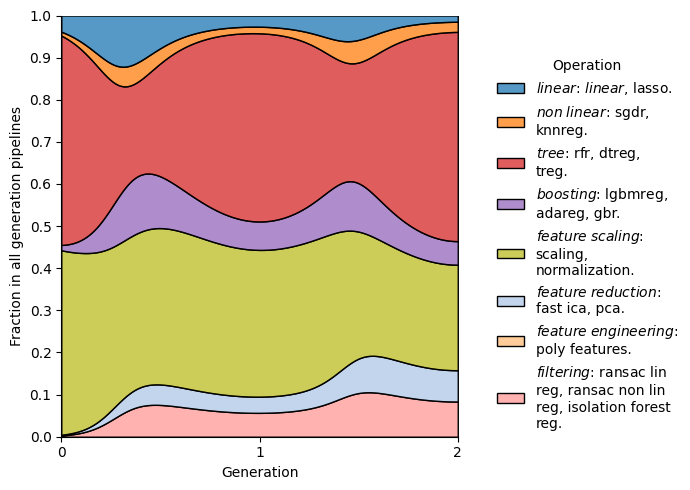

In [52]:
model.history.show.operations_kde(dpi=100)

In [54]:
pipeline.show("pipeline_structure.png", node_size_scale=0.5, dpi=100)

In [55]:
path_to_local = "/home/jupyter-admin/"

# Логгирование парамметров запуска
mlflow.log_param("preset", model.params.api_params['preset'])
mlflow.log_param("timeout", model.params.api_params['timeout'])
mlflow.log_param("cv_folds", model.params.api_params['cv_folds'])

# Логгирование метрик и времени обучения
mlflow.log_metric("rmse", metrics_result['rmse'])
mlflow.log_metric("mae", metrics_result['mae'])
mlflow.log_metric("r2", metrics_result['r2'])
mlflow.log_metric("training_time", (end_time - start_time) / 60)

# логирование структуры в виде графика
mlflow.log_artifact(path_to_local + "pipeline_structure.png")

# логирование модели и истории
mlflow.log_artifact(path_to_pipeline_pkl)
mlflow.log_artifact(path_to_history_pkl)

In [56]:
mlflow.end_run()

mlflow.get_tracking_uri()

'https://ml-platform-3b3039c3f6f64a.ml.msk.vkcs.cloud'

## Послесловие

В данном блокноте мы показали вам как запустить фреймворк **FEDOT** совместно с инструментом логирования **MLflow** для экспериментов и решения задачи регрессии.

Теперь вы можете попробовать провести свои эксперименты.

<i class="fa fa-github" style="font-size:24px"></i> - <a href="https://github.com/nccr-itmo/FEDOT"> Наш репозиторий </a>

<i class="fa fa-telegram" style="font-size:24px;color:blue"></i> - <a href="https://t.me/FEDOT_helpdesk">Telegram канал поддержки</a>

<i class="fa fa-youtube-play" style="font-size:24px;color:red"></i> - <a href="https://www.youtube.com/channel/UC4K9QWaEUpT_p3R4FeDp5jA">Наш канал на Youtube</a>